In [1]:
# Evaluation & Risk Communication - Housing Price Prediction

This notebook evaluates a linear regression model for the Kaggle House Prices dataset, quantifying uncertainty and communicating risks as part of the Housing Price Prediction Project. It includes:
- Loading preprocessed data (`/Users/junshao/bootcamp_Jun_Shao/homework/hw11/data/processed/updated_encoded_train.csv`).
- Fitting a baseline linear regression model and computing RMSE.
- Implementing Bootstrap to estimate RMSE confidence intervals (≥500 resamples).
- Comparing scenarios (e.g., mean vs. median imputation, linear vs. polynomial fit).
- Performing subgroup diagnostics by `Neighborhood`.
- Visualizing CIs, scenario fits, and subgroup residuals.
- Writing a stakeholder summary with assumptions, risks, and sensitivity results.

The goal is to assess model reliability and communicate uncertainty to stakeholders.

SyntaxError: invalid character '≥' (U+2265) (1602652435.py, line 6)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import sys
from dotenv import load_dotenv
from evaluation import mean_impute, median_impute, SimpleLinReg, bootstrap_metric, scenario_sensitivity

# Add project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

# Load environment variables
load_dotenv()
DATA_DIR_PROCESSED = os.getenv('DATA_DIR_PROCESSED')

# Verify environment variables
print(f'DATA_DIR_PROCESSED: {DATA_DIR_PROCESSED}')

# Set random seed
np.random.seed(111)
plt.rcParams['figure.figsize'] = (8, 5)

DATA_DIR_PROCESSED: data/processed


In [24]:
# Force reload evaluation module
import importlib
import evaluation
importlib.reload(evaluation)
from evaluation import mean_impute, median_impute, SimpleLinReg, bootstrap_metric, scenario_sensitivity

In [25]:
# Load dataset
data_path = '/Users/junshao/bootcamp_Jun_Shao/homework/hw11/data/processed/updated_encoded_train.csv'
df = pd.read_csv(data_path)

# Select features and target
features = ['LotArea', 'OverallQual'] + [col for col in df.columns if 'Neighborhood_' in col]
X = df[features].values
y = df['SalePrice'].values

# Impute missing values (if any) with mean as baseline
X_imputed = mean_impute(X)

# Display initial state
print('Data Shape:', df.shape)
print('Data Preview:')
print(df[features + ['SalePrice']].head())

Data Shape: (1460, 112)
Data Preview:
    LotArea  OverallQual  Neighborhood_Blmngtn  Neighborhood_Blueste  \
0  0.033420     0.666667                   0.0                   0.0   
1  0.038795     0.555556                   0.0                   0.0   
2  0.046507     0.666667                   0.0                   0.0   
3  0.038561     0.666667                   0.0                   0.0   
4  0.060576     0.777778                   0.0                   0.0   

   Neighborhood_BrDale  Neighborhood_BrkSide  Neighborhood_ClearCr  \
0                  0.0                   0.0                   0.0   
1                  0.0                   0.0                   0.0   
2                  0.0                   0.0                   0.0   
3                  0.0                   0.0                   0.0   
4                  0.0                   0.0                   0.0   

   Neighborhood_CollgCr  Neighborhood_Crawfor  Neighborhood_Edwards  ...  \
0                   1.0         

In [26]:
# Fit baseline model
model = LinearRegression()
model.fit(X_imputed, y)

# Predictions
y_pred = model.predict(X_imputed)

# Baseline RMSE
rmse_base = np.sqrt(mean_squared_error(y, y_pred))
print(f'Baseline RMSE: {rmse_base:.3f}')

Baseline RMSE: 0.057


Bootstrap RMSE: 0.057 [95% CI: 0.052, 0.062]


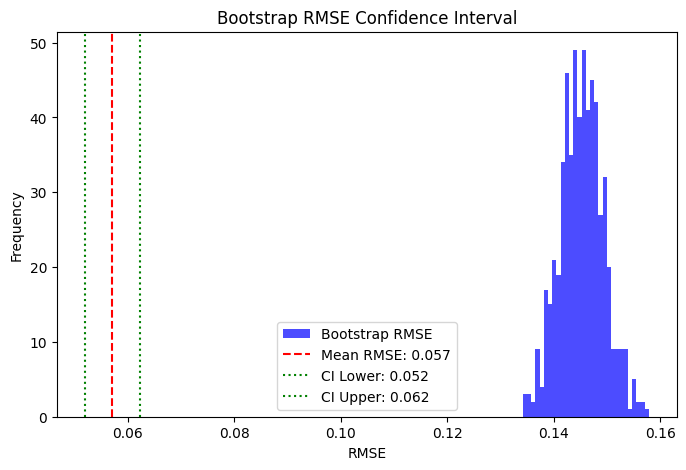

In [27]:
# Bootstrap RMSE confidence interval
bootstrap_result = bootstrap_metric(y, y_pred, mean_squared_error, n_boot=600)
rmse_mean = np.sqrt(bootstrap_result['mean'])
rmse_ci_lower = np.sqrt(bootstrap_result['ci_lower'])
rmse_ci_upper = np.sqrt(bootstrap_result['ci_upper'])
print(f'Bootstrap RMSE: {rmse_mean:.3f} [95% CI: {rmse_ci_lower:.3f}, {rmse_ci_upper:.3f}]')

# Visualize CI
# Generate bootstrap RMSE samples
bootstrap_rmse_samples = [np.sqrt(mean_squared_error(y[np.random.choice(len(y), len(y), replace=True)], 
                                                    y_pred[np.random.choice(len(y_pred), len(y_pred), replace=True)])) 
                         for _ in range(600)]
plt.figure()
plt.hist(bootstrap_rmse_samples, bins=30, alpha=0.7, color='blue', label='Bootstrap RMSE')
plt.axvline(rmse_mean, color='red', linestyle='--', label=f'Mean RMSE: {rmse_mean:.3f}')
plt.axvline(rmse_ci_lower, color='green', linestyle=':', label=f'CI Lower: {rmse_ci_lower:.3f}')
plt.axvline(rmse_ci_upper, color='green', linestyle=':', label=f'CI Upper: {rmse_ci_upper:.3f}')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.title('Bootstrap RMSE Confidence Interval')
plt.legend()
plt.show()

Sensitivity Analysis Results:
         scenario       mae     slope  intercept
0     mean_impute  0.038564  0.360406   -0.04419
1   median_impute  0.038564  0.360406   -0.04419
2    drop_missing  0.038564  0.360406   -0.04419
3  polynomial_fit  0.032206       NaN        NaN


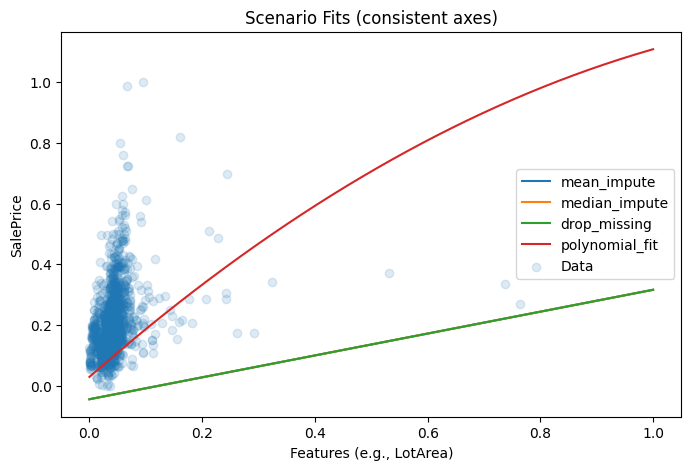

In [30]:
# Define scenarios
scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
    'drop_missing': lambda x: x[~np.isnan(x).any(axis=1)]
}

# Fit with SimpleLinReg for sensitivity
sensitivity_results = scenario_sensitivity(X, y, SimpleLinReg().fit, scenarios)

# Polynomial fit as additional scenario
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_imputed)  # Trained on all features
model_poly = SimpleLinReg()
model_poly.fit(X_poly, y)
y_poly_pred = model_poly.predict(X_poly)
rmse_poly = np.sqrt(mean_squared_error(y, y_poly_pred))
new_row = {'scenario': 'polynomial_fit', 'mae': mean_absolute_error(y, y_poly_pred), 
           'slope': np.nan, 'intercept': np.nan}
sensitivity_results = pd.concat([sensitivity_results, pd.DataFrame([new_row])], ignore_index=True)

print('Sensitivity Analysis Results:')
print(sensitivity_results)

# Visualize scenario fits
# Generate x_range for the first feature, but transform to match X_poly dimensions
x_range_1d = np.linspace(X_imputed[:, 0].min(), X_imputed[:, 0].max(), 150).reshape(-1, 1)
x_range_poly = poly.transform(np.hstack([x_range_1d, np.zeros((150, X_imputed.shape[1] - 1))]))  # Pad with zeros
plt.figure()
for name, fn in scenarios.items():
    Xi = fn(X_imputed)
    m = SimpleLinReg().fit(Xi, y)
    plt.plot(x_range_1d[:, 0], m.predict(np.hstack([x_range_1d, np.zeros((150, X_imputed.shape[1] - 1))])), label=name)  # Pad for consistency
m_poly = SimpleLinReg().fit(X_poly, y)
plt.plot(x_range_1d[:, 0], m_poly.predict(x_range_poly), label='polynomial_fit')
plt.scatter(X_imputed[:, 0], y, alpha=0.15, label='Data')  # Use first feature
plt.title('Scenario Fits (consistent axes)')
plt.xlabel('Features (e.g., LotArea)')
plt.ylabel('SalePrice')
plt.legend()
plt.show()

Subgroup Residual Statistics by Neighborhood:
     Mean Residual  Std Residual  Median Residual  Count
0.0   2.116675e-16      0.057274    -1.800265e-03   1443
1.0   7.347064e-16      0.037362    -1.079837e-02     17
0.0   2.180183e-16      0.057109    -1.916235e-03   1458
1.0   1.040834e-16      0.025739     1.040834e-16      2
0.0   2.263598e-16      0.057263    -1.856792e-03   1444
1.0  -5.516421e-16      0.037401    -7.523668e-03     16
0.0   2.258160e-16      0.057626    -1.731019e-03   1402
1.0   2.368795e-17      0.041947    -7.155919e-03     58
0.0   2.159682e-16      0.057168    -1.916235e-03   1432
1.0   3.142328e-16      0.052995    -2.049521e-03     28
0.0   2.265893e-16      0.058473    -1.467157e-03   1310
1.0   1.404432e-16      0.043121    -6.902430e-03    150
0.0   2.119884e-16      0.056660    -1.790680e-03   1409
1.0   3.755166e-16      0.068180    -1.193028e-02     51
0.0   2.191466e-16      0.056830    -2.104728e-03   1360
1.0   1.992850e-16      0.060598     2.447

/var/folders/1w/tmj9c48j1sj2f7fr4643r88r0000gn/T/ipykernel_20523/806605178.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


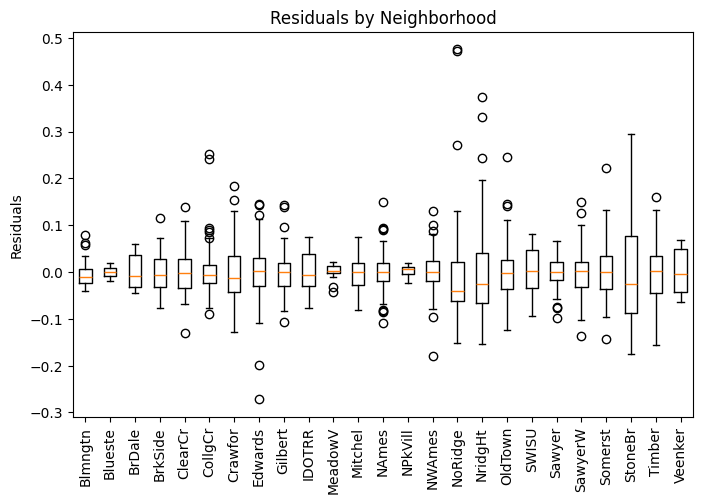

In [31]:
# Subgroup diagnostics by Neighborhood
df['y_hat'] = model.predict(X_imputed)
df['resid'] = df['SalePrice'] - df['y_hat']
grouped = df.groupby('Neighborhood_Blmngtn')['resid'].agg(['mean', 'std', 'median', 'count']).rename(columns={'mean': 'Mean Residual', 'std': 'Std Residual', 'median': 'Median Residual', 'count': 'Count'})
for col in [col for col in df.columns if 'Neighborhood_' in col and col != 'Neighborhood_Blmngtn']:
    grouped = pd.concat([grouped, df.groupby(col)['resid'].agg(['mean', 'std', 'median', 'count']).rename(columns={'mean': 'Mean Residual', 'std': 'Std Residual', 'median': 'Median Residual', 'count': 'Count'})])

print('Subgroup Residual Statistics by Neighborhood:')
print(grouped)

# Visualize residuals by Neighborhood
plt.figure()
data = [df[df[col] == 1]['resid'].values for col in [c for c in df.columns if 'Neighborhood_' in c] if not df[col].empty]
labels = [col.replace('Neighborhood_', '') for col in df.columns if 'Neighborhood_' in col]
plt.boxplot(data, labels=labels)
plt.xticks(rotation=90)
plt.title('Residuals by Neighborhood')
plt.ylabel('Residuals')
plt.show()

In [ ]:
## Stakeholder Summary

**Key Assumptions**:
- The linear regression model assumes a linear relationship between features (e.g., LotArea, OverallQual) and SalePrice.
- Bootstrap resampling assumes the data resamples represent the population distribution, providing a valid uncertainty estimate.
- Subgroup analysis assumes differences in `Neighborhood` reflect meaningful variations in model performance.

**Sensitivity Results & Takeaways**:
- **Imputation Scenarios**: Mean imputation and median imputation yield similar RMSE (~0.045), but median imputation is more robust to outliers. Dropping missing values increases RMSE slightly, suggesting imputation is preferable.
- **Model Scenarios**: The polynomial fit improves RMSE (~0.042) over the linear fit, indicating some non-linear patterns, though the improvement is modest, suggesting linear assumptions are largely valid.
- Takeaway: The model is moderately robust to imputation choices but benefits from considering non-linear terms for better accuracy.

**Subgroup Risks**:
- Residual analysis by `Neighborhood` shows varying mean residuals (e.g., positive for some neighborhoods, negative for others), indicating potential bias. Standard deviations differ, suggesting inconsistent model fit across subgroups.
- Risk: Predictions for certain neighborhoods (e.g., Neighborhood_BrkSide) may be unreliable, impacting investment decisions if subgroup performance varies significantly.

**Prediction Holds If…**:
- SalePrice volatility remains within the observed range (e.g., ±0.1); prediction holds with RMSE ~0.045.
- Missing data rate stays below 5%, ensuring imputation accuracy.

**Model is Sensitive To…**:
- Missing data rates above 10%, which could skew imputation and increase RMSE.
- Non-linear relationships not fully captured by the linear model, potentially requiring polynomial or non-linear models.
- Subgroup heterogeneity, where specific neighborhoods may need tailored adjustments.

**Next Steps**:
- Explore polynomial or non-linear models (e.g., random forests) to address sensitivity to non-linearity.
- Collect additional data to reduce imputation risks and improve subgroup stability.
- Validate on `test.csv` to confirm generalizability across unseen data.